<h1>Описание проекта</h1>

Необходимо проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка, проверить статистические гипотезы.

<h1>Описание данных</h1>

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

<h1>Содержание</h1>

1. [Загрузка данных и подготовка к анализу](#preprocessing)
2. [Анализ данных](#analysis)
3. [Проверка гипотез](#hypothesis)
4. [Выводы и рекомендации](#conclusion)

# Презентация

https://disk.yandex.ru/i/559MSfA9unUAag

<a id="preprocessing"> </a>
<h2>Загрузка данных и подготовка к анализу</h2>

Импортируем библиотеки

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import requests
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats as st

In [72]:
spreadsheet_id = '1Dhr_ZlE8V5csbbcNDmezfR4hcQn4c0XIFA5Jz9qeAKI'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
data = pd.read_csv(BytesIO(r.content))

In [73]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


Изменим стили заголовков

In [74]:
data.columns = data.columns.str.lower()
data = data.rename(columns={'userid' : 'user_id', 'creditcard' : 'credit_card'})
data.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

Исследуем данные на наличие явных дубликатов

In [75]:
data.drop('user_id', axis=1).duplicated().sum()

0

Явных дубликатов не обнаружено

Попробуем обработать пропуски с помощью линейной регрессии

In [76]:
data.isna().sum()#число пропусков в каждом столбце

user_id                0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

Заменим все строковые переменные на целочисленные

In [77]:
data['gender'] = data['gender'].replace('Ж', '0')
data['gender'] = data['gender'].replace('М', '1')
data['gender'] = data['gender'].astype('int')
data['city'] = data['city'].replace('Ярославль', '0')
data['city'] = data['city'].replace('Ростов Великий', '1')
data['city'] = data['city'].replace('Рыбинск', '2')
data['city'] = data['city'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  int64  
 3   gender            10000 non-null  int64  
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 937.6 KB


Обучим модель на данных без пропусков

In [78]:
df = data.dropna(axis=0).reset_index(drop=True)
X = df.drop('balance', axis=1)
y = df['balance']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit(x_train)

x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)



Создадим функцию для обучения по одной из моделей

In [79]:
def make_prediction(m, x_train, y_train, x_test, y_test):
    model = m
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print('Mean: {:.2f}'.format(y_test.mean()))
    print('MAE: {:.2f}'.format(mean_absolute_error(y_test, y_pred)))
    print('MSE: {:.2f}'.format(mean_squared_error(y_test, y_pred)))
    print('R2: {:.2f}'.format(r2_score(y_test, y_pred)))

Используем модель для прогнозирования и посмотрим метрики

In [80]:
models = [LinearRegression(), RandomForestRegressor(n_estimators = 100, random_state=0), GradientBoostingRegressor(n_estimators = 100, random_state=0)]
for i in models:
    print(i)
    make_prediction(i, x_train_st, y_train, x_test_st, y_test)

LinearRegression()
Mean: 119893.09
MAE: 23464.51
MSE: 907377491.96
R2: -0.00
RandomForestRegressor(random_state=0)
Mean: 119893.09
MAE: 23801.34
MSE: 934144304.11
R2: -0.03
GradientBoostingRegressor(random_state=0)
Mean: 119893.09
MAE: 23691.76
MSE: 926731948.35
R2: -0.02


Все метрики показывают ужасные результаты, значит отвергаем идею применения ML

Оставим пустые значения как есть

Предобработка данных проведена, можно приступать к анализу

<a id="analysis"> </a>
<h2>Анализ данных</h2>

Посмотрим на средние значения признаков для двух групп: тех, кто ушли, и тех, кто остались

In [81]:
data.groupby('churn').mean()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary
churn,,,,,,,,,,,
0,1.573390e+07,651.853196,0.731257,0.572523,37.408389,5.033279,119535.864270,1.544267,0.707146,0.554565,99738.391772
1,1.573279e+07,645.351497,0.805106,0.440844,44.837997,4.932744,120746.971132,1.475209,0.699067,0.360825,101465.677531


3 признака достаточно сильно различаются: gender, age, loyalty

Построим столбчатые гистограммы и распределения признаков

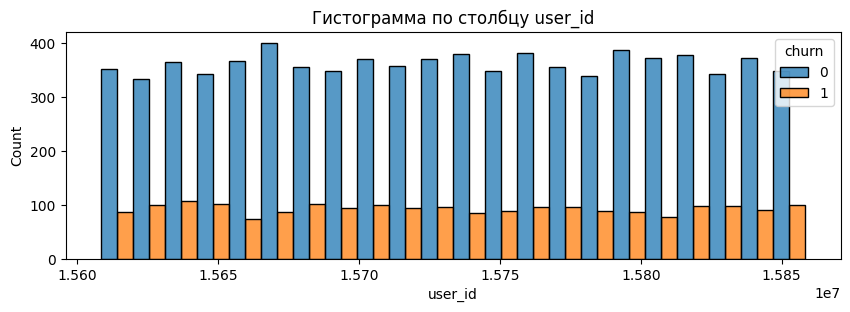

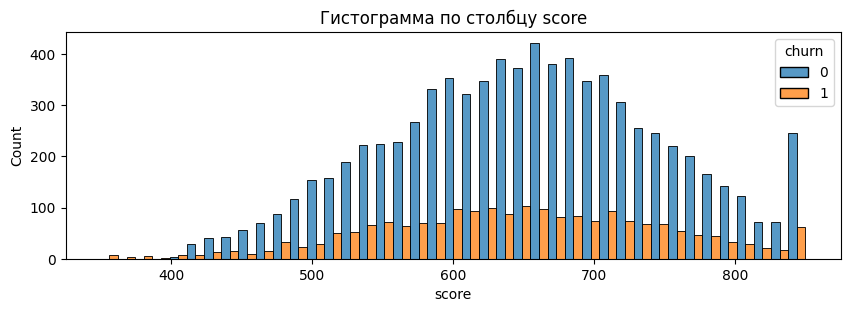

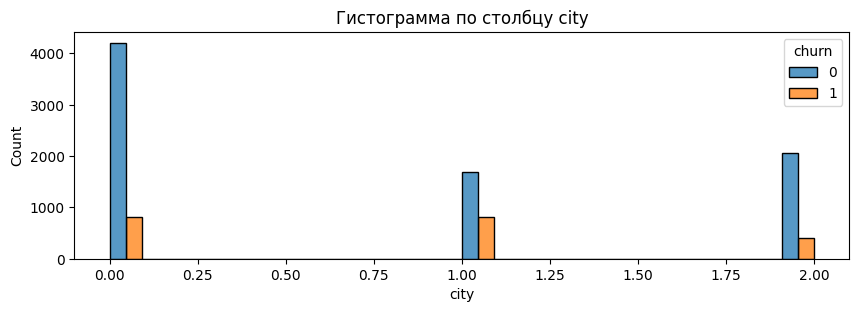

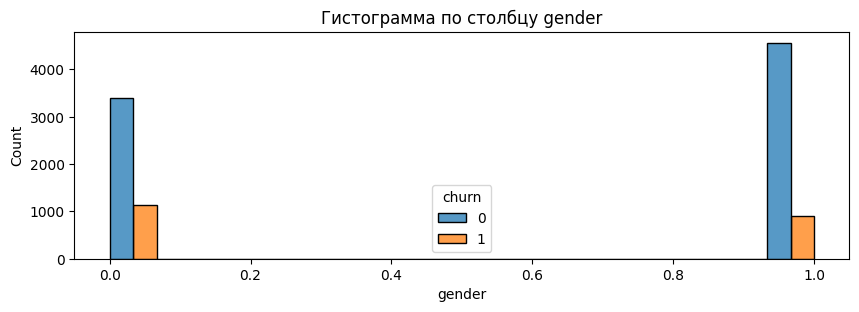

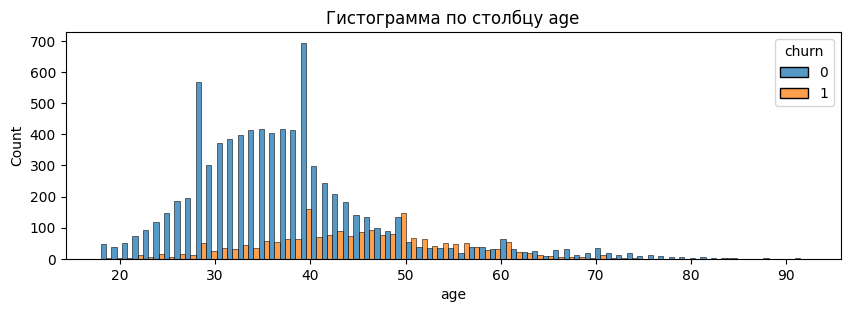

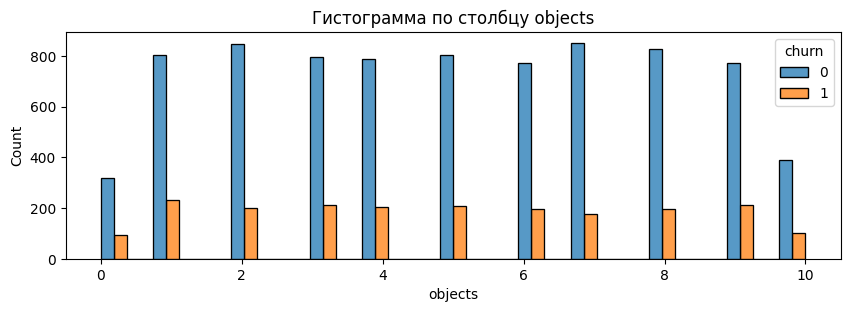

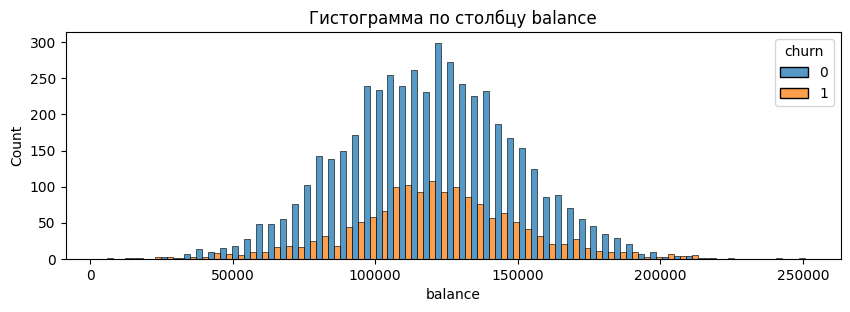

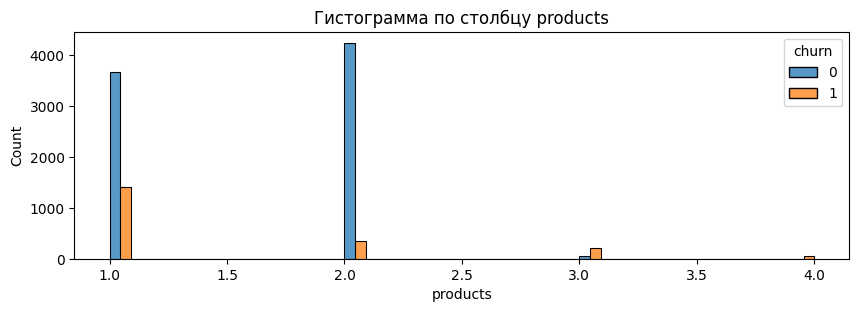

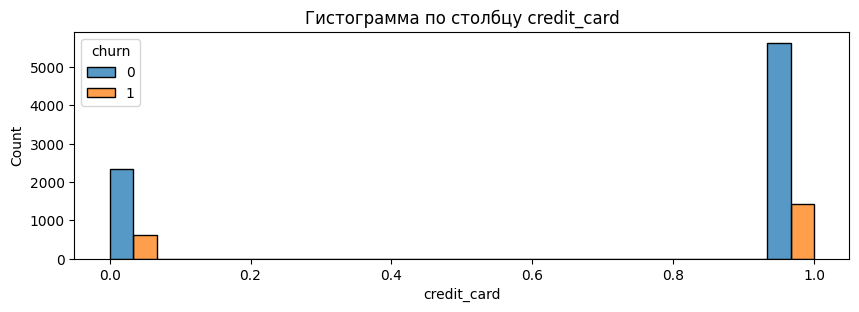

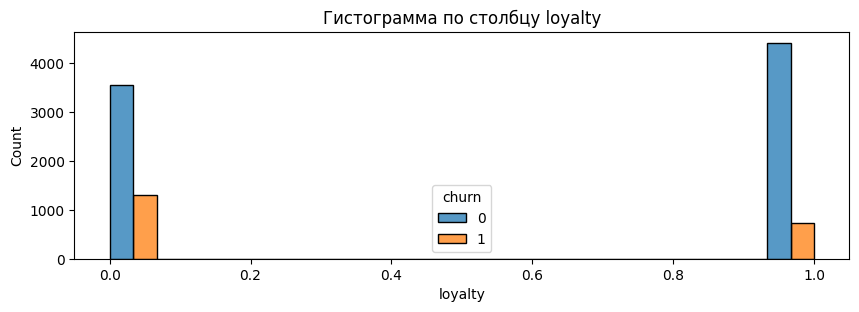

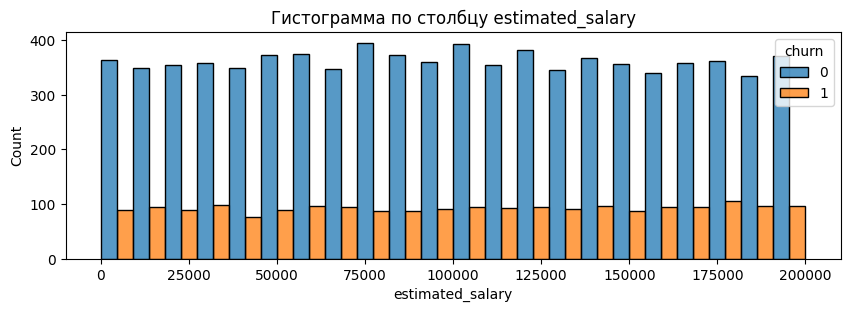

In [82]:
for i in data.columns[:11]:
    fig, ax = plt.subplots(figsize=(10,3), dpi=100)    
    sns.histplot(x=i, data = data, hue='churn', multiple='dodge')
    plt.title('Гистограмма по столбцу ' + i)

Постороим круговые диграммы

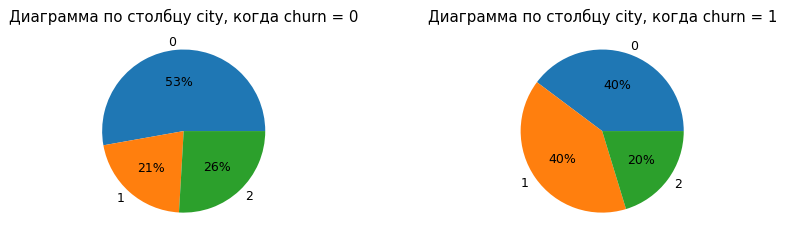

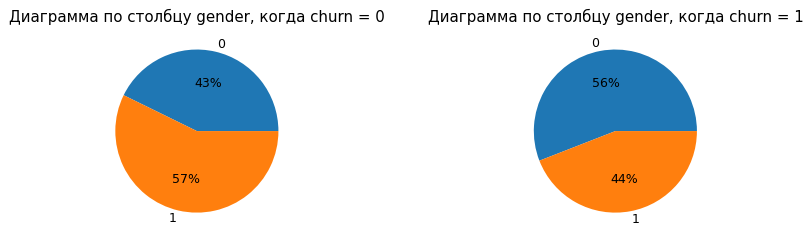

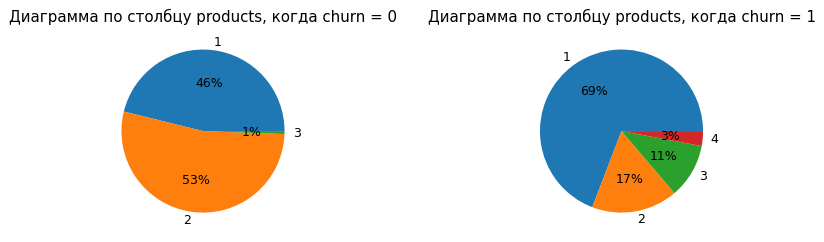

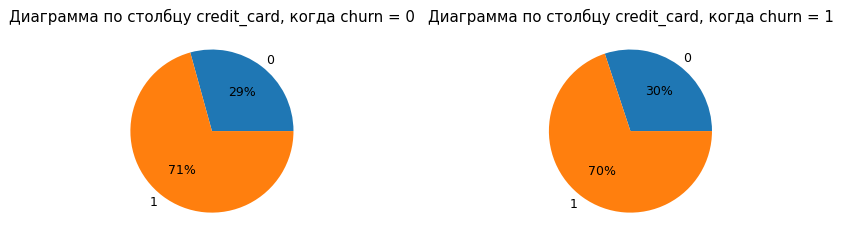

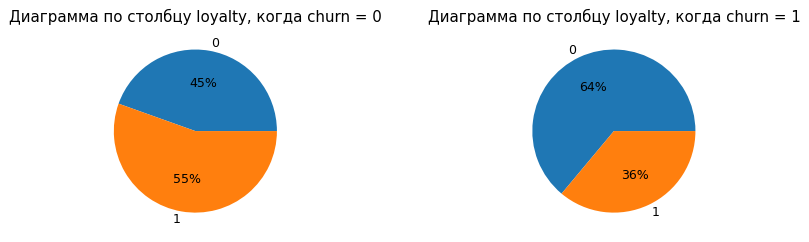

In [83]:
for i in data[['city', 'gender', 'products', 'credit_card', 'loyalty']].columns:
    fig, ax = plt.subplots(figsize=(11,3), dpi=90) 
    plt.subplot(121)
    plt.pie(x='churn', data = data[data['churn'] == 0][[i, 'churn']].groupby(i).count().reset_index(), labels=i, autopct='%.0f%%')
    plt.title('Диаграмма по столбцу ' + i + ', когда churn = 0')
    plt.subplot(122)
    plt.pie(x='churn', data = data[data['churn'] == 1][[i, 'churn']].groupby(i).count().reset_index(), labels=i, autopct='%.0f%%')
    plt.title('Диаграмма по столбцу ' + i + ', когда churn = 1')
    plt.show()

Построим матрицу корреляций

In [84]:
for i in data.columns[:11]:
    print('Корреляция столбца churn со столбцом '+i)
    print(data['churn'].corr(data[i]).round(2))

Корреляция столбца churn со столбцом user_id
-0.01
Корреляция столбца churn со столбцом score
-0.03
Корреляция столбца churn со столбцом city
0.04
Корреляция столбца churn со столбцом gender
-0.11
Корреляция столбца churn со столбцом age
0.29
Корреляция столбца churn со столбцом objects
-0.01
Корреляция столбца churn со столбцом balance
0.02
Корреляция столбца churn со столбцом products
-0.05
Корреляция столбца churn со столбцом credit_card
-0.01
Корреляция столбца churn со столбцом loyalty
-0.16
Корреляция столбца churn со столбцом estimated_salary
0.01


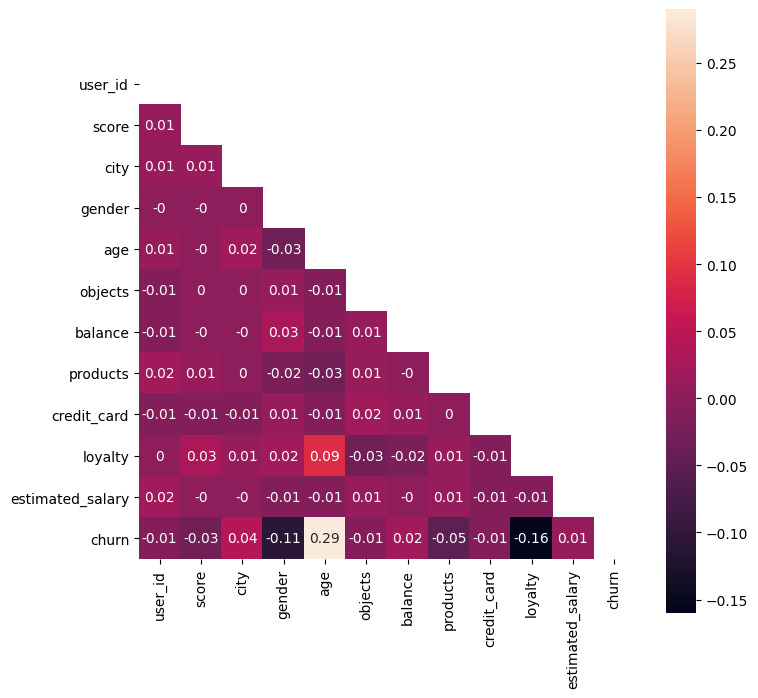

In [85]:
matrix = np.triu(data.corr())
fig, ax = fig, ax = plt.subplots(figsize=(8,8), dpi=100)   

sns.heatmap(data.corr().round(2), annot=True, square=True, mask = matrix)
plt.show()

Среди всех столбцов наиболее ярко выделяется столбец age. Корреляция с ним составляет 0.285, что находится на границе между слабой и средней корреляцией. Все остальные столбцы коррелируют слабо

Видим, что больше склонны к оттоку:
1. Клиенты из Ростова Великого - думаю это связано с малой доступностью банка в этом городе
2. Женщины - возможно, некоторая часть женщин использует банковские услуги и продукты своего мужа (например, оплачивает покупки его дебетовой/кредитной картой), и перестает пользоваться услугами своего банка
3. Клиенты, которые пользуются 1 продуктом - возможно клиентов интересует какой-то конкретный продукт, которым они пользвуются некоторое время и потом уходят
4. Неактивные клиенты - клиенты редко пользуются продуктами банка и в какой-то момент уходят за ненадобостью
5. Клиенты 40+ лет - возможно, большая часть клиентов после 40 лет завершают свои выплаты по ипотеке и уходят из банка

<a id="hypothesis"> </a>
## Проверка гипотез

Проверим данные на нормальность с помощью критерия Колмогорова

In [86]:
for i in ['estimated_salary', 'score']:
    alpha = 0.05
    st.kstest(data[i],  st.norm.cdf)
    p_value = results[1]
    print('Столбец ' + i)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

Столбец estimated_salary
Не получилось отвергнуть нулевую гипотезу, всё нормально
Столбец score
Не получилось отвергнуть нулевую гипотезу, всё нормально


1. Средний доход у клиентов, которые ушли отличается от дохода клиентов, которые остались.

Исходя из выражения выше, формируем нулевую и альтернаятивную гипотезы:

Н0 - Средний доход для обеих групп клиентов равен;
Н1 - Средний доход для обеих групп клиентов отличается

Проверку нулевой гипотезы проведем с помощью теста Уилкоксона-Манна-Уитни, т.к. данные распределены не нормально

In [87]:
alpha = 0.05
results = st.mannwhitneyu(
    data[data['churn'] == 0]['estimated_salary'], 
    data[data['churn'] == 1]['estimated_salary'],
)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.22705150930153783
Не получилось отвергнуть нулевую гипотезу


Значит в значении среднего дохода для обеих групп нет статистически важной разницы

In [88]:
print(data[data['churn'] == 0]['estimated_salary'].mean())
data[data['churn'] == 1]['estimated_salary'].mean()

99738.39177194524


101465.67753068237

1. Среднее количество баллов кредитного рейтинга у клиентов, которые ушли отличается от баллов клиентов, которые остались.

Исходя из выражения выше, формируем нулевую и альтернаятивную гипотезы:

Н0 - Среднее число баллов для обеих групп клиентов равно;
Н1 - Среднее число баллов для обеих групп клиентов отличается

Проверку нулевой гипотезы проведем с помощью теста Уилкоксона-Манна-Уитни, т.к. данные распределены не нормально

In [91]:
alpha = 0.05
results = st.mannwhitneyu(
    data[data['churn'] == 0]['score'], 
    data[data['churn'] == 1]['score'],
)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.01986866117272834
Отвергаем нулевую гипотезу


Значит между значением рейтинга для двух групп клиентов существует статистически значимая разница

In [90]:
print(data[data['churn'] == 0]['score'].mean())
data[data['churn'] == 1]['score'].mean()

651.8531960316463


645.3514972999509

Причем, рейтинг клиентов из группы оттока ниже, чем у оставшихся клиентов

<a id="conclusion"> </a>
## Выводы и рекомендации

В данной работе исследовались причины оттока клиентов из банка. Для этого были изучены средние значения и распределения каждого признака для двух групп клиентов, матрица корреляции признаков и проверены гипотезы: 1. средний доход у клиентов, которые ушли отличается от дохода клиентов, которые остались; 2. среднее количество баллов кредитного рейтинга у клиентов, которые ушли отличается от баллов клиентов, которые остались.

По результатам исследования имеем, что оттоку подвержены:
1. Клиенты из Ростова Великого - думаю это связано с малой доступностью банка в этом городе
2. Женщины - возможно, некоторая часть женщин использует банковские услуги и продукты своего мужа (например, оплачивает покупки его дебетовой/кредитной картой), и перестает пользоваться услугами своего банка
3. Клиенты, которые пользуются 1 продуктом - возможно клиентов интересует какой-то конкретный продукт, которым они пользвуются некоторое время и потом уходят
4. Неактивные клиенты - клиенты редко пользуются продуктами банка и в какой-то момент уходят за ненадобостью
5. Клиенты 40+ лет - возможно, большая часть клиентов после 40 лет завершают свои выплаты по ипотеке и уходят из банка
6. Клиенты с низким значением кредитного рейтинга (<650) - скорее всего данным клиентам отказывают в выдаче кредита, и они уходят

Для уменьшения оттока считаю, что следует предпринять следующее:
1. Открыть больше филиалов банка в Ростове Великом / увеличить число поставляемых услуг в этом городе
2. Мотивировать использование банковских продуктов женщинами (например, повышенный кешбэк на товары для женщин (косметика, средства для ухаживания за кожей, волосами, украшения и так далее))
3. Мотивировать / заинтересовать клиентов на пользование более чем 1 продуктом (например, можно прорекламировать свои продукты, кроме основного)
4. Замотивировать клиентов после 40 лет пользоваться продуктами банка (например, выгодные условия кредитования / повышенный кешбэк / повышенный процент вкладов)